## Dependencies

In [1]:
from openvaccine_scripts import *
import warnings, json
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


SEED = 0
seed_everything(SEED)
warnings.filterwarnings('ignore')

# Model parameters

In [2]:
config = {
  "BATCH_SIZE": 32,
  "EPOCHS": 70,
  "LEARNING_RATE": 1e-3,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "PB_SEQ_LEN": 107,
  "PV_SEQ_LEN": 130,
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BATCH_SIZE': 32,
 'EPOCHS': 70,
 'LEARNING_RATE': 0.001,
 'ES_PATIENCE': 10,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'PB_SEQ_LEN': 107,
 'PV_SEQ_LEN': 130}

# Load data

In [3]:
database_base_path = '/kaggle/input/stanford-covid-vaccine/'
train = pd.read_json(database_base_path + 'train.json', lines=True)
test = pd.read_json(database_base_path + 'test.json', lines=True)

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 2400


,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


Test samples: 3634


,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


## Auxiliary functions

In [4]:
def get_dataset(x, y=None, sample_weights=None, labeled=True, shuffled=True, batch_size=32, buffer_size=-1, seed=0):
    input_map = {'inputs_seq': x['sequence'], 
                 'inputs_struct': x['structure'], 
                 'inputs_loop': x['predicted_loop_type'], 
                 'inputs_bpps_max': x['bpps_max'], 
                 'inputs_bpps_sum': x['bpps_sum'], 
                 'inputs_bpps_scaled': x['bpps_scaled']}
    
    if labeled:
        output_map = {'output_react': y['reactivity'], 
                      'output_bg_ph': y['deg_Mg_pH10'], 
                      'output_ph': y['deg_pH10'], 
                      'output_mg_c': y['deg_Mg_50C'], 
                      'output_c': y['deg_50C']}
        if sample_weights is not None:
            dataset = tf.data.Dataset.from_tensor_slices((input_map, output_map, sample_weights))
        else:
            dataset = tf.data.Dataset.from_tensor_slices((input_map, output_map))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((input_map))
    
    if shuffled:
        dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size)
    
    return dataset

# Pre-process

In [5]:
# Add bpps as features
bpps_max = []
bpps_sum = []
bpps_scaled = []
bpps_nb_mean = 0.077522 # mean of bpps_nb across all training data
bpps_nb_std = 0.08914   # std of bpps_nb across all training data
for row in train.itertuples():
    probability = np.load(f'{database_base_path}/bpps/{row.id}.npy')
    bpps_max.append(probability.max(-1).tolist())
    bpps_sum.append((1-probability.sum(-1)).tolist())
    # bpps nb
    bpps_nb = (probability > 0).sum(axis=0) / probability.shape[0]
    bpps_nb = (bpps_nb - bpps_nb_mean) / bpps_nb_std
    bpps_scaled.append(bpps_nb)
train = train.assign(bpps_max=bpps_max, bpps_sum=bpps_sum, bpps_scaled=bpps_scaled)

bpps_max = []
bpps_sum = []
bpps_scaled = []
for row in test.itertuples():
    probability = np.load(f'{database_base_path}/bpps/{row.id}.npy')
    bpps_max.append(probability.max(-1).tolist())
    bpps_sum.append((1-probability.sum(-1)).tolist())
    # bpps nb
    bpps_nb = (probability > 0).sum(axis=0) / probability.shape[0]
    bpps_nb = (bpps_nb - bpps_nb_mean) / bpps_nb_std
    bpps_scaled.append(bpps_nb)
test = test.assign(bpps_max=bpps_max, bpps_sum=bpps_sum, bpps_scaled=bpps_scaled)


feature_cols = ['sequence', 'structure', 'predicted_loop_type', 'bpps_max', 'bpps_sum', 'bpps_scaled']
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
encoder_list = [token2int_seq, token2int_struct, token2int_loop, None, None, None]

public_test = test.query("seq_length == 107").copy()
private_test = test.query("seq_length == 130").copy()

x_test_public = get_features_dict(public_test, feature_cols, encoder_list, public_test.index)
x_test_private = get_features_dict(private_test, feature_cols, encoder_list, private_test.index)

# To use as stratified col
train['signal_to_noise_int'] = train['signal_to_noise'].astype(int)

# Model

In [6]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.
  
    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape == (..., seq_len_k, depth)
      v: value shape == (..., seq_len_v, depth_v)
      mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
    
    Returns:
     output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

class MultiHeadAttention(L.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = L.Dense(d_model)
        self.wk = L.Dense(d_model)
        self.wv = L.Dense(d_model)

        self.dense = L.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'depth': self.depth,
            'wq': self.wq,
            'qk': self.wk,
            'wv': self.wv,
            'dense': self.dense,
        })
        
        return config
def point_wise_feed_forward_network(d_model, dff):
      return tf.keras.Sequential([
      L.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      L.Dense(d_model)                  # (batch_size, seq_len, d_model)
  ])

class EncoderLayer(L.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = L.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = L.LayerNormalization(epsilon=1e-6)

        self.dropout1 = L.Dropout(rate)
        self.dropout2 = L.Dropout(rate)
    
    def call(self, x, training):
        #mask made None
        attn_output, _ = self.mha(x, x, x, None)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_heads': self.num_heads,
            'rate': self.rate,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dropout1': self.dropout1,
            'dropout2': self.dropout2,
            'layernorm1': self.layernorm1,
            'layernorm2': self.layernorm2,
            'mha': self.mha,
            'ffn': self.ffn,
        })
        return config

In [7]:
def model_fn(embed_dim=200, hidden_dim=384, dropout=.5, pred_len=68, n_outputs=5):
    inputs_seq  = L.Input(shape=(None, 1), name='inputs_seq')  
    inputs_struct  = L.Input(shape=(None, 1), name='inputs_struct')  
    inputs_loop  = L.Input(shape=(None, 1), name='inputs_loop')
    inputs_bpps_max  = L.Input(shape=(None, 1), name='inputs_bpps_max')
    inputs_bpps_sum  = L.Input(shape=(None, 1), name='inputs_bpps_sum')
    inputs_bpps_scaled  = L.Input(shape=(None, 1), name='inputs_bpps_scaled')

    
    input_concat = L.concatenate([inputs_seq, inputs_struct, inputs_loop], axis=-1, name='input_concat')
    
    ### Encoder block
    # Embedding block
    embed = L.Embedding(input_dim=len(token2int), output_dim=embed_dim, name='embedding')(input_concat)
    embed_reshaped = L.Reshape((-1, embed.shape[2]*embed.shape[3]))(embed)
    embed_reshaped = L.SpatialDropout1D(.2)(embed_reshaped)
    
    x_concat = L.concatenate([embed_reshaped, inputs_bpps_max, inputs_bpps_sum, inputs_bpps_scaled], axis=-1, name='feature_concatenate')
    
    # Conv block
    encoder = L.Conv1D(filters=256, kernel_size=5, padding='same')(x_concat)

    # Transformer encoder block
#     encoder = EncoderLayer(conv.shape[2], 8, 256)(encoder)

    # Recurrent block
    encoder, encoder_state_f, encoder_state_b = L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True, 
                                                                      return_state=True, kernel_initializer='orthogonal'), 
                                                                name='Encoder_RNN')(encoder)
        
    
    ### Decoder block
    decoder = L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True, kernel_initializer='orthogonal'), 
                              name='Decoder')(encoder, initial_state=[encoder_state_f, encoder_state_b])
    
    # Since we are only making predictions on the first part of each sequence, we have to truncate it
    decoder_truncated = decoder[:, :pred_len]
    
    output_react = L.Dense(1, name='output_react')(decoder_truncated)
    output_bg_ph = L.Dense(1, name='output_bg_ph')(decoder_truncated)
    output_ph = L.Dense(1, name='output_ph')(decoder_truncated)
    output_mg_c = L.Dense(1, name='output_mg_c')(decoder_truncated)
    output_c = L.Dense(1, name='output_c')(decoder_truncated)
    
    
    model = Model(inputs=[inputs_seq, inputs_struct, inputs_loop, inputs_bpps_max, inputs_bpps_sum, inputs_bpps_scaled], 
                  outputs=[output_react, output_bg_ph, output_ph, output_mg_c, output_c])

    opt = optimizers.Adam(learning_rate=config['LEARNING_RATE'])
    model.compile(optimizer=opt, loss={'output_react': MCRMSE, 
                                       'output_bg_ph': MCRMSE, 
                                       'output_ph': MCRMSE, 
                                       'output_mg_c': MCRMSE, 
                                       'output_c': MCRMSE},
                                 loss_weights={'output_react': 2., 
                                               'output_bg_ph': 2., 
                                               'output_ph': 1., 
                                               'output_mg_c': 2., 
                                               'output_c': 1.})

    return model

model = model_fn()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_seq (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
inputs_struct (InputLayer)      [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
inputs_loop (InputLayer)        [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_concat (Concatenate)      (None, None, 3)      0           inputs_seq[0][0]                 
                                                                 inputs_struct[0][0]   

# Training

In [8]:
AUTO = tf.data.experimental.AUTOTUNE
skf = KFold(n_splits=config['N_FOLDS'], shuffle=True, random_state=SEED)
history_list = []

oof = train[['id', 'SN_filter', 'signal_to_noise'] + pred_cols].copy()
oof_preds = np.zeros((len(train), 68, len(pred_cols)))
test_public_preds = np.zeros((len(public_test), config['PB_SEQ_LEN'], len(pred_cols)))
test_private_preds = np.zeros((len(private_test), config['PV_SEQ_LEN'], len(pred_cols)))

for fold,(train_idx, valid_idx) in enumerate(skf.split(train['signal_to_noise_int'])):
    if fold >= config['N_USED_FOLDS']:
        break
    print(f'\nFOLD: {fold+1}')
    
    ### Create datasets
    x_train = get_features_dict(train, feature_cols, encoder_list, train_idx)
    x_valid = get_features_dict(train, feature_cols, encoder_list, valid_idx)
    y_train = get_targets_dict(train, pred_cols, train_idx)
    y_valid = get_targets_dict(train, pred_cols, valid_idx)
    w_train = np.log(train.iloc[train_idx]['signal_to_noise'].values+1.2)+1
    w_valid = np.log(train.iloc[valid_idx]['signal_to_noise'].values+1.2)+1
    
    
    train_ds = get_dataset(x_train, y_train, w_train, labeled=True, shuffled=True, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)
    valid_ds = get_dataset(x_valid, y_valid, w_valid, labeled=True, shuffled=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)
    oof_ds = get_dataset(get_features_dict(train, feature_cols, encoder_list, valid_idx), labeled=False, shuffled=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)
    test_public_ds = get_dataset(x_test_public, labeled=False, shuffled=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)
    test_private_ds = get_dataset(x_test_private, labeled=False, shuffled=False, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, seed=SEED)


    ### Model
    K.clear_session()
    model = model_fn()

    model_path = f'model_{fold}.h5'
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], restore_best_weights=True, verbose=1)
    rlrp = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, verbose=1)
    
    ### Train
    history = model.fit(train_ds,
                        validation_data=valid_ds,
                        callbacks=[es, rlrp],
                        epochs=config['EPOCHS'],
                        batch_size=config['BATCH_SIZE'],
                        verbose=2).history
      
    history_list.append(history)
    # Save last model weights
    model.save_weights(model_path)

    ### Inference
    oof_ds_preds = np.array(model.predict(oof_ds)).reshape((len(pred_cols), len(valid_idx), 68)).transpose((1, 2, 0))
    oof_preds[valid_idx] = oof_ds_preds
    
    # Short sequence (public test)
    model = model_fn(pred_len=config['PB_SEQ_LEN'])
    model.load_weights(model_path)
    test_public_ds_preds = np.array(model.predict(test_public_ds)).reshape((len(pred_cols), len(public_test), 
                                                                            config['PB_SEQ_LEN'])).transpose((1, 2, 0))
    test_public_preds += test_public_ds_preds * (1 / config['N_USED_FOLDS'])
    
    # Long sequence (private test)
    model = model_fn(pred_len=config['PV_SEQ_LEN'])
    model.load_weights(model_path)
    test_private_ds_preds = np.array(model.predict(test_private_ds)).reshape((len(pred_cols), len(private_test), 
                                                                              config['PV_SEQ_LEN'])).transpose((1, 2, 0))
    test_private_preds += test_private_ds_preds * (1 / config['N_USED_FOLDS'])


FOLD: 1
Epoch 1/70
60/60 - 6s - loss: 9.4651 - output_react_loss: 1.0208 - output_bg_ph_loss: 1.2150 - output_ph_loss: 1.4237 - output_mg_c_loss: 1.1933 - output_c_loss: 1.1833 - val_loss: 7.9610 - val_output_react_loss: 0.8338 - val_output_bg_ph_loss: 1.0294 - val_output_ph_loss: 1.1693 - val_output_mg_c_loss: 1.0250 - val_output_c_loss: 1.0154
Epoch 2/70
60/60 - 4s - loss: 8.2801 - output_react_loss: 0.8806 - output_bg_ph_loss: 1.0498 - output_ph_loss: 1.2412 - output_mg_c_loss: 1.0516 - output_c_loss: 1.0750 - val_loss: 7.7105 - val_output_react_loss: 0.8030 - val_output_bg_ph_loss: 0.9951 - val_output_ph_loss: 1.1435 - val_output_mg_c_loss: 0.9894 - val_output_c_loss: 0.9922
Epoch 3/70
60/60 - 4s - loss: 8.0233 - output_react_loss: 0.8528 - output_bg_ph_loss: 1.0169 - output_ph_loss: 1.2096 - output_mg_c_loss: 1.0157 - output_c_loss: 1.0429 - val_loss: 7.4172 - val_output_react_loss: 0.7768 - val_output_bg_ph_loss: 0.9553 - val_output_ph_loss: 1.1043 - val_output_mg_c_loss: 0.9521

## Model loss graph


FOLD: 1
Train 4.51531 Validation 5.41639

FOLD: 2
Train 4.29823 Validation 6.08134

FOLD: 3
Train 4.45777 Validation 5.56378

FOLD: 4
Train 4.37128 Validation 5.73351

FOLD: 5
Train 4.11857 Validation 5.99364


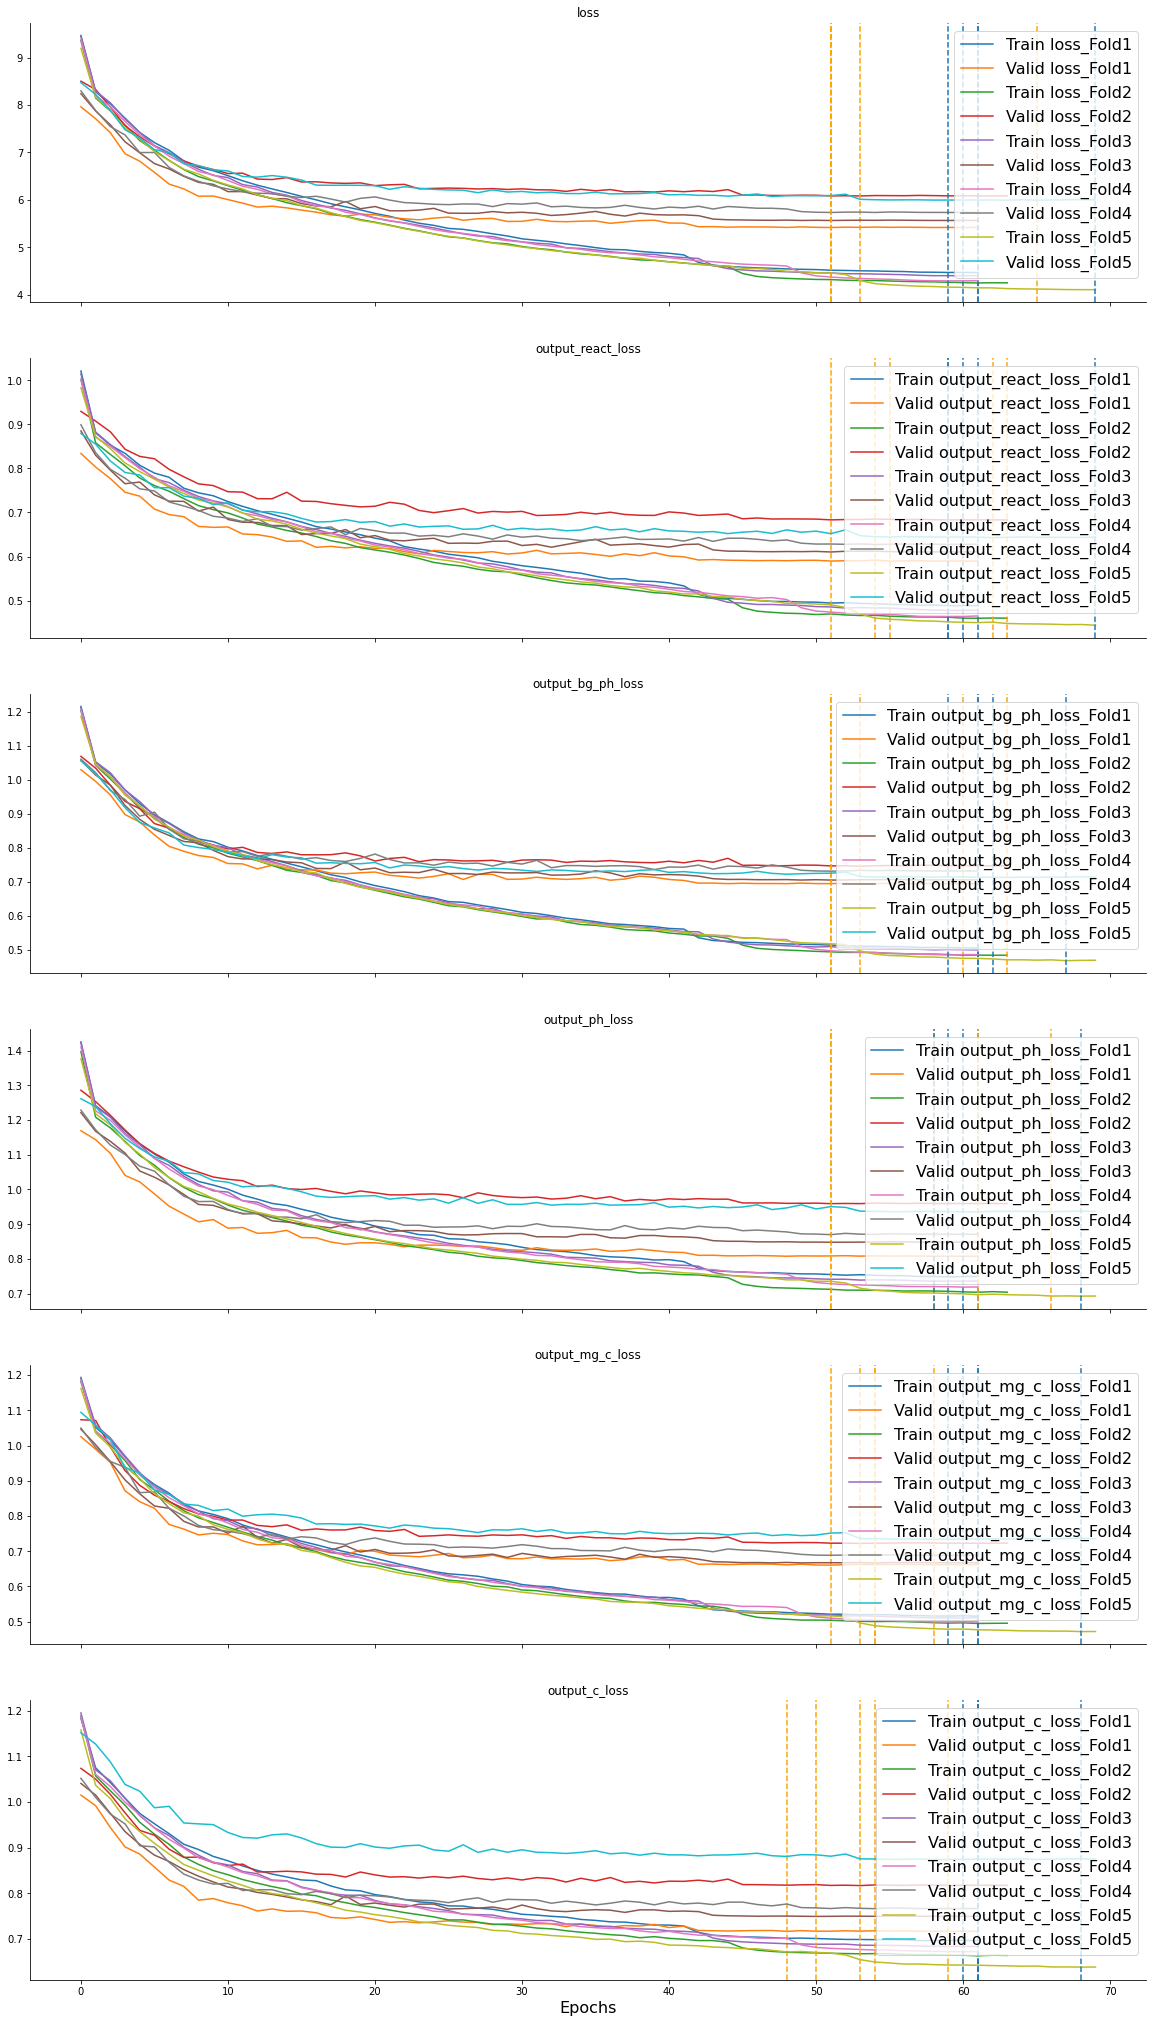

In [9]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    min_valid_idx = np.array(history['val_loss']).argmin()
    print(f"Train {np.array(history['loss'])[min_valid_idx]:.5f} Validation {np.array(history['val_loss'])[min_valid_idx]:.5f}")

plot_metrics_agg(history_list)

# Post-processing

In [10]:
# Assign preds to OOF set
for idx, col in enumerate(pred_cols):
    val = oof_preds[:, :, idx]
    oof = oof.assign(**{f'{col}_pred': list(val)})
    
oof.to_csv('oof.csv', index=False)

oof_preds_dict = {}
for col in pred_cols:
    oof_preds_dict[col] = oof_preds[:, :, idx]

# Assign values to test set
preds_ls = []

for df, preds in [(public_test, test_public_preds), (private_test, test_private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=pred_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_ls.append(single_df)

preds_df = pd.concat(preds_ls)

# Model evaluation

In [11]:
y_true_dict = get_targets_dict(train, pred_cols, train.index)
y_true = np.array([y_true_dict[col] for col in pred_cols]).transpose((1, 2, 0, 3)).reshape(oof_preds.shape)

display(evaluate_model(train, y_true, oof_preds, pred_cols))
display(evaluate_model(train, y_true, oof_preds, pred_cols, use_cols=['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']))

,Metric/MCRMSE,Complete,Clean (SN),Noisy (SN),Clean (signal),Noisy (signal)
0,Overall,0.818438,0.219140,1.369652,0.233940,2.207655
1,reactivity,0.601465,0.200647,0.995831,0.205846,1.601202
2,deg_Mg_pH10,0.541716,0.252767,0.862116,0.253931,1.368275
3,deg_pH10,1.170597,0.234445,1.986817,0.258909,3.218067
4,deg_Mg_50C,0.732345,0.206749,1.226137,0.220674,1.974443
5,deg_50C,1.046067,0.201093,1.777360,0.230341,2.876289


,Metric/MCRMSE,Complete,Clean (SN),Noisy (SN),Clean (signal),Noisy (signal)
0,Overall,0.625175,0.220054,1.028028,0.226817,1.647973
1,reactivity,0.601465,0.200647,0.995831,0.205846,1.601202
2,deg_Mg_pH10,0.541716,0.252767,0.862116,0.253931,1.368275
3,deg_Mg_50C,0.732345,0.206749,1.226137,0.220674,1.974443


# Visualize test predictions

In [12]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission = submission[['id_seqpos']].merge(preds_df, on=['id_seqpos'])

# Test set predictions

In [13]:
display(submission.head(10))
display(submission.describe())

submission.to_csv('submission.csv', index=False)

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.716208,0.615255,1.993595,0.506921,0.795331
1,id_00073f8be_1,2.174021,3.081143,4.096010,3.007567,2.766559
2,id_00073f8be_2,1.494643,0.629865,0.630590,0.672561,0.648996
3,id_00073f8be_3,1.278935,1.070023,1.138648,1.564454,1.766035
4,id_00073f8be_4,0.740628,0.516404,0.379496,0.765646,0.777404
5,id_00073f8be_5,0.666672,0.549695,0.505660,0.699569,0.724511
6,id_00073f8be_6,0.721809,0.944876,0.918605,1.064586,1.023100
7,id_00073f8be_7,0.816282,1.051464,1.260592,1.116814,1.510410
8,id_00073f8be_8,0.167546,0.684707,0.611618,0.843778,0.611425
9,id_00073f8be_9,0.089759,0.353933,0.356698,0.381312,0.525170


,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
count,457953.000000,457953.000000,457953.000000,457953.000000,457953.000000
mean,0.321601,0.410515,0.382223,0.336478,0.355716
std,0.371070,0.398667,0.432370,0.388383,0.341168
min,-0.270004,-1.049896,-2.287182,-1.934831,-1.944983
25%,0.063101,0.179092,0.137510,0.089060,0.113330
50%,0.183706,0.297995,0.284591,0.243002,0.285066
75%,0.467006,0.510351,0.482882,0.470205,0.531034
max,4.091196,5.274818,5.886397,4.468988,3.646874
